# Лабораторная работа №2

- Взять 2 изображения со сдвигом
- Подготовить изображения
- Определить на каждой фотографии ключевые точки
- Отфильтровать самые наилучшие
- Построить по каждой точке дескриптор (можете использовать любой, рекомендуется SIFT)
- Сопоставить два соседних изображения на предмет соответствия ключевых точек
- Построить траекторию движения камеры

Подключаем библиотеки и гугл диск:

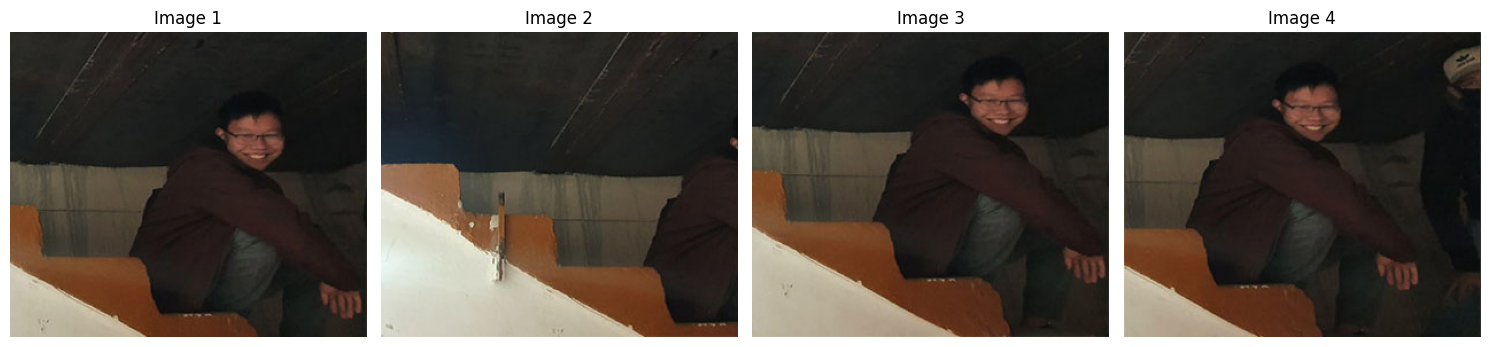

In [1]:
# импортируем библиотеки
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
from scipy.ndimage import gaussian_filter, laplace
from scipy.spatial import cKDTree

# Путь к папке с исходными изображениями
input_folder = 'data/'  # Папка с изображениями

# Получаем список всех изображений в папке (например, все файлы с расширением .jpg или .png)
image_paths = glob.glob(os.path.join(input_folder, '*.jpg'))

# Список для хранения изображений
images = []

# Цикл для обработки каждого изображения
for image_path in image_paths:
      # Загрузка изображения
      image = cv2.imread(image_path)

      # Конвертация из BGR в RGB для корректного отображения в matplotlib
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Добавление изображения в список
      images.append(image_rgb)

# Вывод изображений с помощью matplotlib
if images:
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')  # Отключаем оси
        ax.set_title(f"Image {i+1}")  # Название для каждого изображения

    plt.tight_layout()
    plt.show()

## Перевод в grayscsale

Возьмем несколько изображений, сделанных со сдвигом камеры. Переведем их в grayscale.

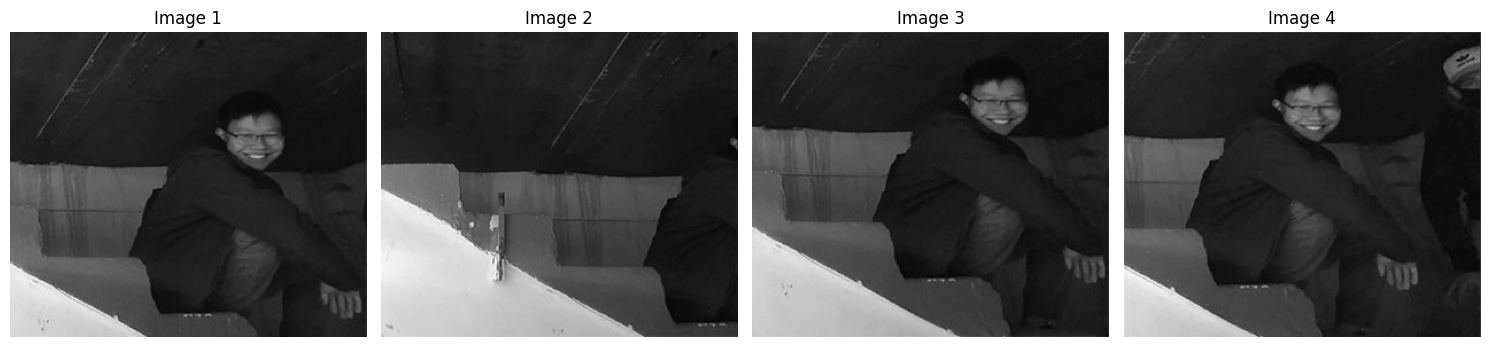

In [5]:
# Путь к папке с исходными изображениями
input_folder = 'data/'
image_paths = glob.glob(os.path.join(input_folder, '*.jpg'))

# Список для хранения grayscale-изображений
gray_images = []

# Цикл для обработки каждого изображения
for image_path in image_paths:
      # Загрузка цветного изображения
      color_image = cv2.imread(image_path)
      gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

      gray_images.append(gray_image)

# Вывод
if gray_images:
    fig, axes = plt.subplots(1, len(gray_images), figsize=(15, 5))

    for i, ax in enumerate(axes):
        ax.imshow(gray_images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

## Выравнивание яркости

Дескриптор ключевой точки (keypoint descriptor) — это числовое представление окрестности ключевой точки, которое описывает её уникальные характеристики.  
Разная яркость изображений может повлиять на формирование дескриптора, а при сопоставлении изображений многие алгоритмы опираются на сравнение дескрипторов ключевых точек.

Для выравнивания яркости будем использовать метод линейной трансформации яркости и выровняем яркость каждого изображения относительно первого.  
Этот метод изменит яркость и контраст второго изображения так, чтобы его среднее значение (mean) и стандартное отклонение (std) стали равны соответствующим значениям первого изображения.


In [6]:
# Загрузка первого изображения как эталона
reference_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)

# Вычисление среднего значения и стандартного отклонения для первого изображения
mean_ref, std_ref = cv2.meanStdDev(reference_image)
mean_ref, std_ref = mean_ref[0][0], std_ref[0][0]

# Списки для хранения данных гистограмм
old_histogram_data = []
new_histogram_data = []
labels = []

# Список для хранения выровненных изображений
aligned_images = []

colors = plt.cm.tab10.colors  # Используем набор цветов tab10 для уникальности
# Обработка каждого изображения
for i, image_path in enumerate(image_paths):
    # Загрузка текущего изображения
    current_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Сохраняем старые значения яркости
    old_brightness_values = current_image.ravel()
    old_histogram_data.append(old_brightness_values)

    # Вычисление среднего значения и стандартного отклонения для текущего изображения
    mean_curr, std_curr = cv2.meanStdDev(current_image)
    mean_curr, std_curr = mean_curr[0][0], std_curr[0][0]

    # Нормализация текущего изображения относительно первого
    adjusted_image = cv2.convertScaleAbs(
        current_image,
        alpha=(std_ref / std_curr),  # Масштабирование контраста
        beta=(mean_ref - mean_curr)  # Корректировка яркости
    )

    # Добавление выровненного изображения в список
    aligned_images.append(adjusted_image)

    # Сохраняем новые значения яркости
    new_brightness_values = adjusted_image.ravel()
    new_histogram_data.append(new_brightness_values)

    # Добавляем метку для легенды
    labels.append(f"Image {i+1}")

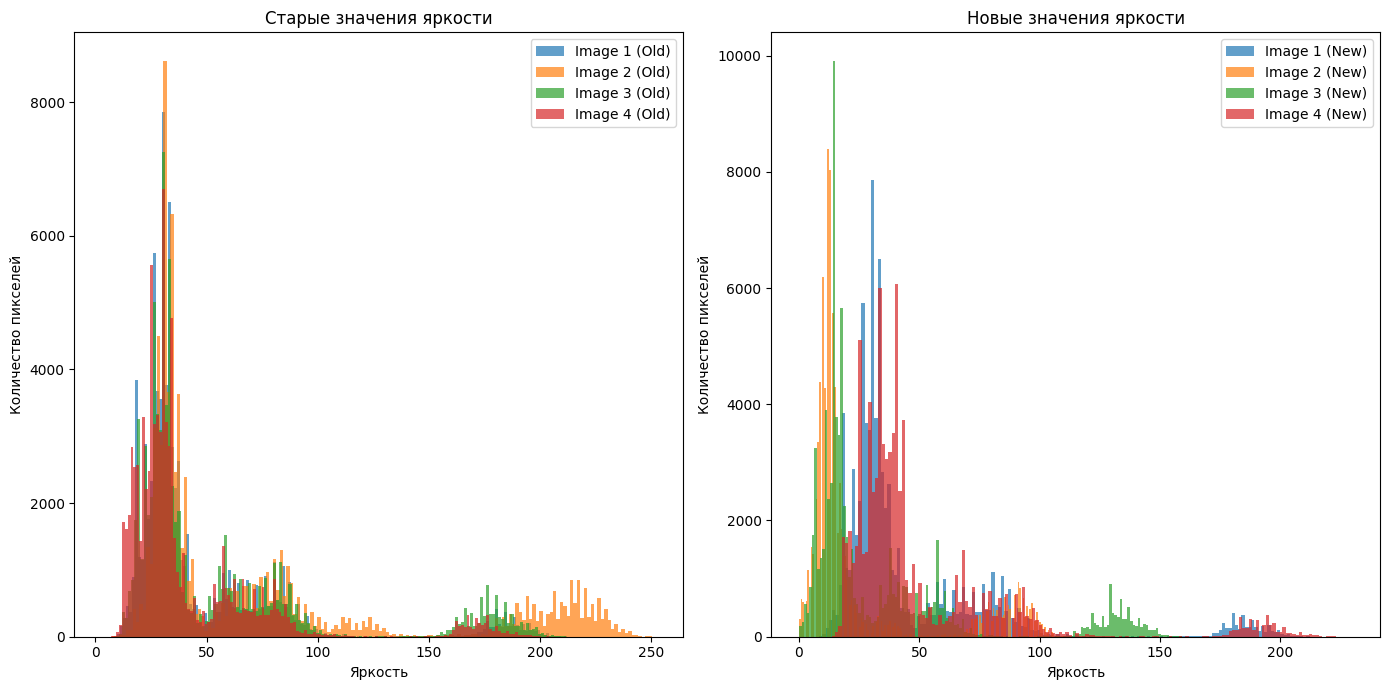

In [7]:
# Построение гистограмм
plt.figure(figsize=(14, 7))

# Гистограммы старых значений яркости
plt.subplot(1, 2, 1)
for i, (data, color, label) in enumerate(zip(old_histogram_data, colors, labels)):
    plt.hist(data, bins=160, color=color, alpha=0.7, label=f"{label} (Old)")
plt.title('Старые значения яркости')
plt.xlabel('Яркость')
plt.ylabel('Количество пикселей')
plt.legend()

# Гистограммы новых значений яркости
plt.subplot(1, 2, 2)
for i, (data, color, label) in enumerate(zip(new_histogram_data, colors, labels)):
    plt.hist(data, bins=160, color=color, alpha=0.7, label=f"{label} (New)")
plt.title('Новые значения яркости')
plt.xlabel('Яркость')
plt.ylabel('Количество пикселей')
plt.legend()

# Отображение гистограмм
plt.tight_layout()
plt.show()

## Поиск ключевых точек

В данном случае поиск ключевых точек осуществлялся с помощью детектора Харриса и Лаплассиана. Первоначально каждое изображение обрабатывается фильтром Гаусса, чтобы сгладить картинку и не тратить ресурсы на незначительные кандидаты в ключевые точки. Далее вычисляется Лапласиан: это оператор, вычисляющий сумму вторых производных интенсивности. Он находит локальные максимумы и минимумы, которые являются областями с наибольшими градиентами. Из Лапласиана далее сформируется "маска", по которой будет работать детектор Харриса, что значительно упростит его вычисления.

### Расчет детектора Харриса с Лплассианом

Вычислим ответ детектора Харриса для каждого пикселя на нескольких изображениях, используя Лапласиан для предварительной фильтрации точек.

In [8]:
def compute_harris(images, k=0.04, sigma=1.6):
    harris_responses = []

    for image in images:
        # Применяем предварительное размытие для уменьшения шума
        blurred_image = gaussian_filter(image, sigma=sigma)

        # Вычисляем Лапласиан
        laplacian = laplace(blurred_image, mode='constant')

        # Находим локальные максимумы/минимумы Лапласиана
        maxima_map = (laplacian > 0) & (gaussian_filter(laplacian, sigma=sigma) > 0.01 * np.max(laplacian))
        minima_map = (laplacian < 0) & (gaussian_filter(laplacian, sigma=sigma) < -0.01 * np.min(laplacian))
        extrema_map = maxima_map | minima_map

        # Вычисляем градиенты через численное дифференцирование
        grad_x = np.gradient(blurred_image, axis=1)
        grad_y = np.gradient(blurred_image, axis=0)

        Ixx = gaussian_filter(grad_x**2, sigma=sigma)
        Iyy = gaussian_filter(grad_y**2, sigma=sigma)
        Ixy = gaussian_filter(grad_x * grad_y, sigma=sigma)

        # Вычисляем определитель и след матрицы гауссиана
        det_M = Ixx * Iyy - Ixy**2
        trace_M = Ixx + Iyy

        # Вычисляем ответ Харриса только для точек, являющихся экстремумами Лапласиана
        harris_response = np.zeros_like(image, dtype=np.float32)
        harris_response[extrema_map] = det_M[extrema_map] - k * trace_M[extrema_map]**2

        harris_responses.append(harris_response)

    return harris_responses

### Поиск точек

Найдем все ключевые точки на основе ответа детектора Харриса, исключая лишние по пороговому значению threshold.

In [9]:
def detect_corners(harris_response, threshold=0.01):

    # Применяем порог для фильтрации слабых точек
    corner_map = harris_response > threshold * np.max(harris_response)

    # Находим все угловые точки
    keypoints = []
    for i in range(corner_map.shape[0]):
        for j in range(corner_map.shape[1]):
            if corner_map[i, j]:
                keypoints.append((i, j))  # Добавляем координаты точки

    return keypoints

Функция отрисовки ключевых точек

In [10]:
def draw_keypoints(images, keypoints_list, titles=None):

    num_images = len(images)

    # Создаем subplot'ы для каждого изображения
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        image = images[i]
        keypoints = keypoints_list[i]

        # Преобразуем изображение в RGB для рисования точек
        image_with_keypoints = np.stack([image] * 3, axis=-1).astype(np.uint8)

        # Рисуем каждую ключевую точку
        for kp in keypoints:
            i_kp, j_kp = kp
            radius = 3
            color = (0, 255, 0)

            # Рисуем круг вокруг ключевой точки
            image_with_keypoints = cv2.circle(
                image_with_keypoints,
                (int(j_kp), int(i_kp)),  # Координаты (x, y)
                radius,
                color,)

        # Устанавливаем заголовок, если он предоставлен
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Image {i+1}")

        ax.imshow(image_with_keypoints)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Результат:

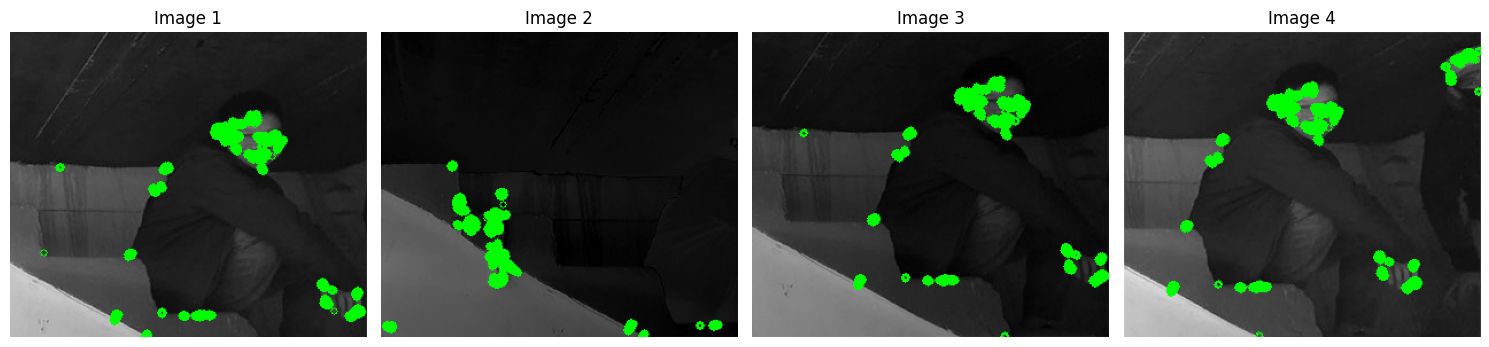

In [11]:
# Вычисление ответа детектора Харриса с использованием Лапласиана
harris_responses = compute_harris(aligned_images, k=0.04, sigma=1.6)

# Поиск ключевых точек для каждого изображения
keypoints_list = []
for harris_response in harris_responses:
    keypoints = detect_corners(harris_response, threshold=0.01)
    keypoints_list.append(keypoints)

# Вывод
draw_keypoints(aligned_images, keypoints_list, titles=None)

### Вычисление размера ключевой точки

Для использования адаптивного радиуса необходимо расчитать размер области вокруг ключевой точки на основе масштаба.
    
- scales_per_octave: Количество уровней в октаве

In [12]:
def compute_keypoint_size(sigma=1.6, scales_per_octave=3):

    k = 2 ** (1 / scales_per_octave)  # Коэффициент увеличения сигмы
    keypoint_size = sigma * k * 3  # Умножаем на 3 для приближения к радиусу области
    return keypoint_size

### Фильтрация ключевых точек адаптивным радиусом

Полученные точки будут отфильтрованы с помощью метода адаптивного радиуса: сначала все полученнные ключевые точки будут отсортированы по степени яркости. В заданном радиусе вокруг первой в списке точки будут убраны все остальные так, чтобы осталась самая значимая. Далее функция пройдется по всему списку, чтобы в заданном радиусе вокруг точек не осталось лишних. Таким образом, останутся самые значимые точки.

In [13]:
def adaptive_radius(keypoints_list, images, min_distance_ratio=0.6):

    filtered_keypoints_list = []

    for keypoints, image in zip(keypoints_list, images):
        filtered_keypoints = []

        # Определяем средний размер области для каждой точки
        sigma = 1.6  # Начальное стандартное отклонение для оценки размера области
        scales_per_octave = 3  # Количество уровней в октаве

        for kp in keypoints:
            i_kp, j_kp = kp

            # Вычисляем адаптивный радиус для текущей точки
            adaptive_radius = compute_keypoint_size(sigma=sigma, scales_per_octave=scales_per_octave) * min_distance_ratio

            # Проверяем расстояние до уже добавленных точек
            is_too_close = False
            for fk in filtered_keypoints:
                distance = np.linalg.norm(np.array([i_kp, j_kp]) - np.array(fk))
                if distance < adaptive_radius + compute_keypoint_size(sigma=sigma, scales_per_octave=scales_per_octave) * min_distance_ratio:
                    is_too_close = True
                    break

            if not is_too_close:
                filtered_keypoints.append((i_kp, j_kp))

        filtered_keypoints_list.append(filtered_keypoints)

    return filtered_keypoints_list

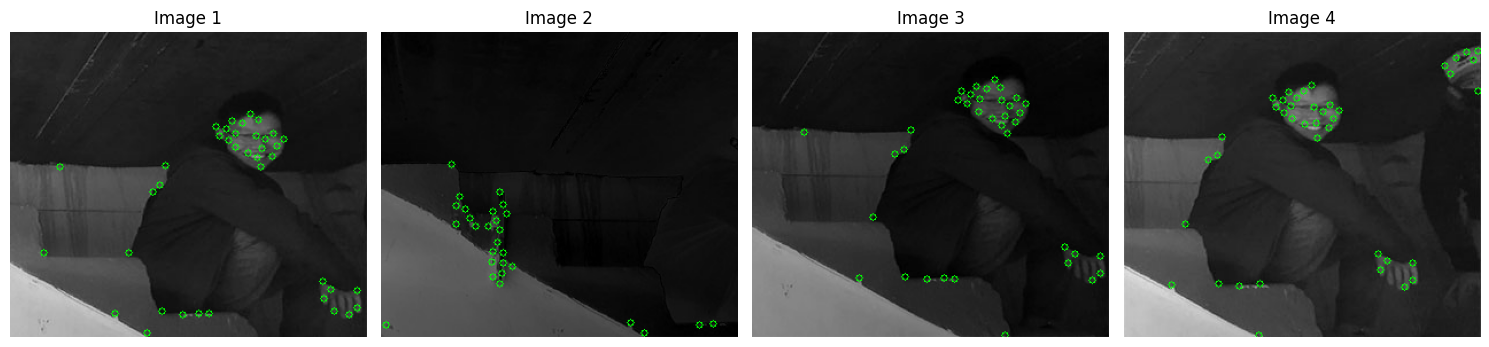

In [14]:
# Вывод
filtered_keypoints_list = adaptive_radius(keypoints_list, aligned_images, min_distance_ratio=0.7)
draw_keypoints(aligned_images, filtered_keypoints_list, titles=None)

## Сопоставление точек

### Вычисление дескрипторов

Для сопоставления точек между изображениями необходимо посчитать дескрипторы: векторы признаков, которые описывают окрестность ключевой точки. Для каждой точки определяется окно анализа, в котором вычисляются градиенты, а после - их магнитуды и направления. Далее пиксели в выбранном окне "голосуют" за бин, соответствующий его направлению градиента, после чего формируется гистограмма ориентаций как массив значений каждого бина.

In [15]:
def compute_descriptors(images, keypoints_list, descriptor_size=16, num_bins=8, sigma=1.6):

    descriptors_list = []

    for image, keypoints in zip(images, keypoints_list):
        descriptors = []

        # Применяем предварительное размытие для уменьшения шума
        blurred_image = gaussian_filter(image, sigma=sigma)

        # Вычисляем Лапласиан
        laplacian = laplace(blurred_image, mode='constant')

        # Находим локальные максимумы/минимумы Лапласиана
        maxima_map = (laplacian > 0) & (gaussian_filter(laplacian, sigma=sigma) > 0.01 * np.max(laplacian))
        minima_map = (laplacian < 0) & (gaussian_filter(laplacian, sigma=sigma) < -0.01 * np.min(laplacian))

        extrema_map = maxima_map | minima_map

        # Вычисляем градиенты через численное дифференцирование
        grad_x = np.gradient(blurred_image, axis=1)
        grad_y = np.gradient(blurred_image, axis=0)

        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        gradient_orientation = np.arctan2(grad_y, grad_x)

        for kp in keypoints:
            i_kp, j_kp = kp

            # Определяем размер окна вокруг ключевой точки
            window_size = int(round(descriptor_size * sigma))
            i_min = max(0, i_kp - window_size // 2)
            i_max = min(image.shape[0], i_kp + window_size // 2 + 1)
            j_min = max(0, j_kp - window_size // 2)
            j_max = min(image.shape[1], j_kp + window_size // 2 + 1)

            local_patch = gradient_magnitude[i_min:i_max, j_min:j_max]
            local_orientations = gradient_orientation[i_min:i_max, j_min:j_max]

            # Строим гистограмму ориентаций
            histogram = np.zeros(num_bins)
            bin_width = 2 * np.pi / num_bins

            for u in range(local_patch.shape[0]):
                for v in range(local_patch.shape[1]):
                    magnitude = local_patch[u, v]
                    orientation = local_orientations[u, v]

                    bin_idx = int((orientation + np.pi) / bin_width) % num_bins
                    histogram[bin_idx] += magnitude

            # Нормализация дескриптора
            descriptor = histogram / (np.linalg.norm(histogram) + 1e-7)
            descriptors.append(descriptor)

        descriptors_list.append(np.array(descriptors))

    return descriptors_list

### Поиск соответствий между дескрипторами
Сопоставление будет осуществляться с помощью cKDTree: этот метод строит дерево, разделяющее пространство пополам по одной из координат для поиска дескриптора, ближайшего к заданному.

In [16]:
def match_descriptors(descriptors_list, distance_threshold=0.8):

    matches_list = []

    # Создаем дерево кД для быстрого поиска ближайших соседей
    for i in range(len(descriptors_list)):
        for j in range(i + 1, len(descriptors_list)):
            descriptors1 = descriptors_list[i]
            descriptors2 = descriptors_list[j]

            tree = cKDTree(descriptors2)  # Дерево для второго набора дескрипторов

            # Находим два ближайших соседа для каждого дескриптора первого изображения
            distances, indices = tree.query(descriptors1, k=2)

            # Применяем тест Лоу для фильтрации соответствий
            good_matches = []
            for idx, (dist1, dist2) in enumerate(zip(distances[:, 0], distances[:, 1])):
                if dist1 < distance_threshold * dist2:
                    good_matches.append((i, idx, j, indices[idx][0]))

            matches_list.append(good_matches)

    return matches_list

In [17]:
def draw_matches(images, keypoints_list, matches_list):

    # Создаем объединенное изображение
    combined_image = np.hstack(images)

    plt.figure(figsize=(20, 5))
    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')

    # Рисуем ключевые точки и соответствия
    for match in matches_list:
        img1_idx, kp1_idx, img2_idx, kp2_idx = match
        kp1 = keypoints_list[img1_idx][kp1_idx]
        kp2 = keypoints_list[img2_idx][kp2_idx]

        # Вычисляем смещения для координат точек
        offset1 = sum(image.shape[1] for image in images[:img1_idx])  # Смещение для первого изображения
        offset2 = sum(image.shape[1] for image in images[:img2_idx])  # Смещение для второго изображения

        # Координаты точек с учетом смещений
        x1, y1 = kp1[1] + offset1, kp1[0]
        x2, y2 = kp2[1] + offset2, kp2[0]

        # Рисуем линию между точками
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)

    plt.show()

### Сопоставление

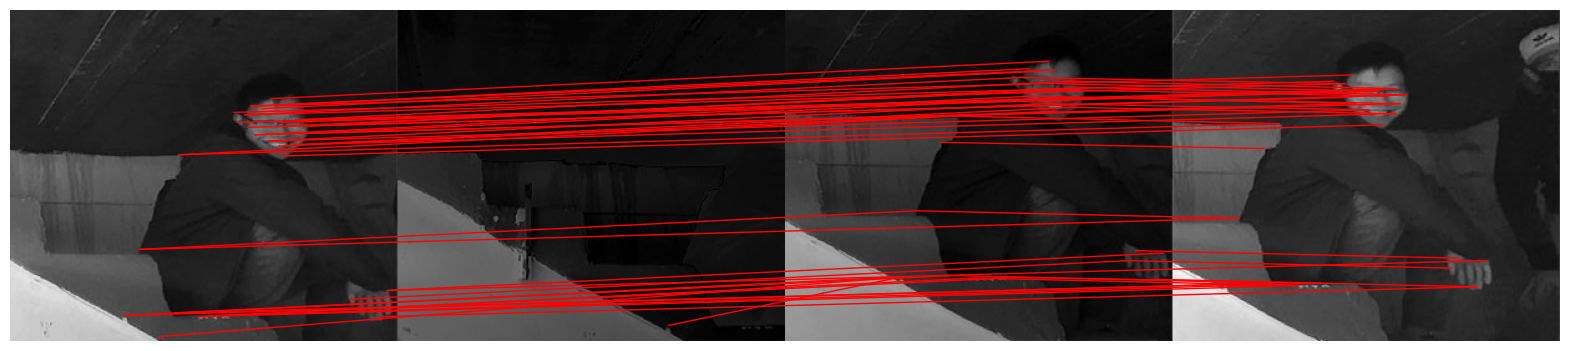

In [18]:
# Вычисление дескрипторов для всех изображений
descriptors_list = compute_descriptors(aligned_images, filtered_keypoints_list)

# Сопоставление дескрипторов между всеми парами изображений
matches_list = []
for i in range(len(descriptors_list)):
    for j in range(i + 1, len(descriptors_list)):
        descriptors1 = descriptors_list[i]
        descriptors2 = descriptors_list[j]

        tree = cKDTree(descriptors2)  # Дерево для второго набора дескрипторов
        distances, indices = tree.query(descriptors1, k=2)

        # Применяем тест Лоу для фильтрации соответствий
        good_matches = []
        for idx, (dist1, dist2) in enumerate(zip(distances[:, 0], distances[:, 1])):
            if dist1 < 0.3 * dist2:  # Сохраняем только хорошие соответствия
                good_matches.append((i, idx, j, indices[idx][0]))

        matches_list.extend(good_matches)

# Вывод
draw_matches(aligned_images, filtered_keypoints_list, matches_list)